# Design Thinking for Document Data Exploration from the Prototype code
**Group 6-Members**
* 110C51505 張仁程
* 110C51537 王星文
* 110C51522 謝安
* 110C51526	蔡侑芯
* 110C51533	陳毓庭
* 110C51520	楊文均

In [ ]:
#如果在Windows或Linux環境上請跑此段。
#請先pip install gdown.
import gdown

url = 'https://drive.google.com/uc?export=download&id=10G2D9fm3UL92W2UuKdrw4bzJkDu0OflJ'
output = '/Code/NTUTDS/patent_documents/patentdoc.tar.gz'
#請使用自己的path
gdown.download(url, output, quiet=False)

In [21]:
#如果在Windows或Linux環境上請跑此段。
import os
import tarfile

def tar_extract(file_path):
    tar = tarfile.open(file_path, 'r:gz')
    tar.extractall()
    tar.close()

if __name__ == '__main__':
    file_path = '/Code/NTUTDS/patent_documents/patentdoc.tar.gz'
    tar_extract(file_path)
#請使用自己的path

In [ ]:
#老師原始程式碼，在Colab上請跑此段。
#!wget "https://drive.google.com/uc?export=download&id=10G2D9fm3UL92W2UuKdrw4bzJkDu0OflJ" -O patentdoc.tar.gz
#!tar xvfz patentdoc.tar.gz

In [ ]:
#資料抓取與處理
import pprint
from bs4 import BeautifulSoup
path = "patent_documents"
patent_csv = {}
patent_number = []
pub_date = [] 
country = []
app_type = []
app_date = []
patent_title = []
patent_abstract = []
applicant_name = []
inv_name = []
ipc_list = []
for filename in os.listdir(path):
  if filename.endswith(".txt"):
    with open(os.path.join(path, filename), 'r') as f:
      soup = BeautifulSoup(f.read(), 'xml')
      panum = soup.find("publication-reference").findChild("doc-number").contents # contents抓出來的東西資料類型是list...
      for pn in panum:
            patent_number.append(pn)
      pdate = soup.find("publication-reference").findChild("date").contents
      for pd in pdate:
             pub_date.append(pd)
      ctry = soup.find("publication-reference").findChild("country").contents
      for ct in ctry:
            country.append(ct)
      app_ref = soup.find("application-reference") #這個不要輸出
      atype = [app_ref['appl-type']]
      for at in atype:
            app_type.append(at)
      adate = app_ref.findChild("date").contents
      for ad in adate:
            app_date.append(ad)
      ptitle = [soup.find("invention-title").getText()] #要想辦法再把/n去掉
      for pt in ptitle:
            patent_title.append(pt)
      pabs = [soup.find("abstract").getText()] #要想辦法再把/n去掉
      for ab in pabs:
            patent_abstract.append(ab)
      #Agents = soup.find("orgname").getText() #如果文件沒有orgname這邊會return error
      us_applicants = soup.find("us-applicants") #這個不要輸出
      app_firstname = us_applicants.findChild("first-name").contents
      app_lastname = us_applicants.findChild("last-name").contents
      aname = [' '.join([a+b for a,b in zip(app_firstname,app_lastname)])] #記得之後要解決a跟b中間沒空格的問題 
      for an in aname:
               applicant_name.append(an)
      inventors = soup.find("inventors") #這個不要輸出
      inv_firstname = inventors.findChild("first-name").contents
      inv_lastname = inventors.findChild("last-name").contents
      iname = [' '.join([c+d for c,d in zip(inv_firstname,inv_lastname)])] #記得之後要解決a跟b中間沒空格的問題
      for ina in iname:
            inv_name.append(ina)
      ipcr_ref = soup.find("classification-ipcr") #這個不要輸出
      ipcr_section = ipcr_ref.findChild("section").contents
      ipcr_class = ipcr_ref.findChild("class").contents
      for class_num in ipcr_class:
            if len(str(class_num))==1:
                  class_num = str("0") + class_num
      ipcr_subclass = ipcr_ref.findChild("subclass").contents
      ipcs = [' '.join([d+e+f for d,e,f in zip(ipcr_section,ipcr_class,ipcr_subclass)])]
      for ip in ipcs:
            ipc_list.append(ip)

patent_csv = {"1.Patent Number":list(patent_number),"2.Publication Date":list(pub_date),"3.Application Date":list(app_date),"4.Country":list(country),"5.Application Type":list(app_type),"6.Title":list(patent_title),"7.Abstract":list(patent_abstract),"8.Applicant":list(applicant_name),"9.Inventor":list(inv_name),"IPCs":list(ipc_list)}

type(patent_csv)

patent_csv.pop('7.Abstract', None)

print(len(patent_csv))
pprint.pprint(patent_csv)

In [3]:
#使用Pandas匯出表格並存成CSV，也可以匯出給關聯式資料庫
import pandas as pd
df = pd.DataFrame.from_dict(patent_csv,orient='index').T
df.head(10)
df.to_csv("patent_table.csv",index=False)

,1.Patent Number,2.Publication Date,3.Application Date,4.Country,5.Application Type,6.Title,8.Applicant,9.Inventor,IPCs
0,08438662,20130514,20101119,US,utility,Face protector lens assembly and method of use,Jerry DeanWright,Jerry DeanWright,A61F
1,08438663,20130514,20110407,US,utility,Face protector lens assembly and method of use,Jerry DeanWright,Jerry DeanWright,A61F
2,08438664,20130514,20100824,US,utility,Rapid intervention rescue harness,Thomas J.Fee,Thomas J.Fee,A41D
3,08438665,20130514,20110801,US,utility,Hooded garment with adjustable hood side porti...,ColinRoemer,ColinRoemer,A41D
4,08438666,20130514,20091116,US,utility,Ear warmer with adjustability,Brian EdwardLe Gette,Brian EdwardLe Gette,A42B
5,08438667,20130514,20090924,US,utility,Apparel incorporating a protective element,DanielaGrogro,DanielaGrogro,A41D
6,08438668,20130514,20100517,US,utility,Occipital stabilization strap for helmets,LouisGarneau,LouisGarneau,A42B
7,08438669,20130514,20110519,US,utility,Apparel incorporating a protective element,DavidTurner,DavidTurner,A41D
8,08438670,20130514,20090825,US,utility,High performance siphonic toilet capable of op...,DavidGrover,DavidGrover,E03D
9,08438671,20130514,20091208,US,utility,Automated pool-deck lid lift system for below ...,Harry J.Last,Harry J.Last,E04H


In [3]:
#Deal only claim texts
from bs4 import BeautifulSoup
import pprint
path = "patent_documents"
patent_docs_txt = {}
for filename in os.listdir(path):
  if filename.endswith(".txt"):
    with open(os.path.join(path, filename), 'r') as f:
      soup = BeautifulSoup(f.read(), 'xml')
      tag = soup.find_all("claims")
      patent_docs_txt[filename] = tag[0].text.lower().replace('\n',' ')

pprint.pprint(patent_docs_txt, depth=1, width=10000)

{'US08438662-20130514.txt': "  1. a face protector, comprising: a face plate having portions configured to protect the forehead, cheeks, jaw, chin, mouth, ears, and nose of a wearer, the face plate having a front opening configured for positioning over the eyes of a wearer and extending rearwardly over opposite sides of the face towards the ears of a wearer; and a lens assembly secured in the front opening of the face plate; the lens assembly comprising at least a first, retainer lens secured in the front opening and substantially flush with at least the forehead portion of the face plate, the first lens being of shape and dimensions which substantially match the shape and dimensions of the front opening, and a second lens of smaller dimensions secured behind the first lens to provide a lens-in-a-lens configuration, wherein the second lens is an automatic darkening filter (adf) lens, the first lens is a filter and has a cover portion of at least substantially transparent material in fr

In [4]:
import re
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk_stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def Patent_KW50(patent_text):
  tokens = nltk.word_tokenize(patent_text)
  wnl = ([lemmatizer.lemmatize(token) for token in tokens])
  nouns = [word for (word, pos) in nltk.pos_tag(wnl) if(pos[:2] == 'NN')] #只取出名詞
  fdist = nltk.FreqDist(nouns)
  common50 = fdist.most_common(50)
  common50_new1 = [(k,v) for k,v in common50 if not re.fullmatch(r"^.$", k)]
  common50_new2 = [(k,v) for k,v in common50_new1 if re.fullmatch(r"^[a-z]+$", k, flags=re.IGNORECASE)]
  stopword = list(nltk_stopwords)[:500] + ['cited','claim','us','fig','et','may','al','according']
  common50_new3 = dict([(k,v) for k,v in common50_new2 if not k in stopword])
  return common50_new3

patent_docs_KW = {}
for doc_name, txt in patent_docs_txt.items():
  patent_docs_KW[doc_name] = Patent_KW50(txt)

pprint.pprint(patent_docs_KW, width=1000)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ellom\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ellom\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ellom\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


{'US08438662-20130514.txt': {'activity': 2, 'adf': 9, 'assembly': 24, 'cheek': 2, 'chin': 2, 'comprises': 6, 'comprising': 4, 'configuration': 3, 'cover': 14, 'curvature': 8, 'darkening': 7, 'dimension': 13, 'ear': 3, 'eye': 5, 'face': 47, 'fastener': 4, 'filter': 9, 'forehead': 2, 'frame': 5, 'front': 15, 'ha': 4, 'height': 2, 'inch': 6, 'jaw': 2, 'lens': 125, 'material': 2, 'member': 6, 'method': 7, 'mouth': 2, 'opening': 24, 'plate': 19, 'portion': 14, 'property': 10, 'protector': 31, 'range': 2, 'rear': 2, 'replacement': 1, 'retainer': 10, 'section': 4, 'set': 11, 'shade': 13, 'shape': 8, 'side': 3, 'step': 5, 'surface': 1, 'vision': 3, 'wearer': 14, 'wherein': 4, 'width': 2},
 'US08438663-20130514.txt': {'activity': 2, 'adf': 3, 'assembly': 20, 'attachment': 4, 'cheek': 2, 'chin': 2, 'comprising': 4, 'configuration': 2, 'cover': 24, 'curvature': 2, 'darkening': 4, 'depth': 3, 'dimension': 6, 'ear': 3, 'eye': 5, 'face': 39, 'fastener': 6, 'filter': 4, 'forehead': 2, 'frame': 14, 'f

{'lens': 125, 'face': 47, 'protector': 31, 'opening': 24, 'assembly': 24, 'plate': 19, 'front': 15, 'portion': 14, 'wearer': 14, 'cover': 14, 'dimension': 13, 'shade': 13, 'set': 11, 'retainer': 10, 'property': 10, 'filter': 9, 'adf': 9, 'shape': 8, 'curvature': 8, 'darkening': 7}


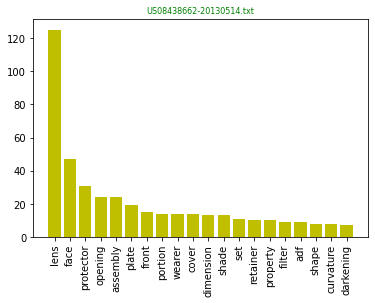

1
{'lens': 76, 'face': 39, 'protector': 25, 'cover': 24, 'assembly': 20, 'wearer': 14, 'opening': 14, 'outer': 14, 'frame': 14, 'portion': 11, 'plate': 10, 'magnifying': 9, 'spacer': 9, 'front': 8, 'set': 7, 'shape': 6, 'dimension': 6, 'fastener': 6, 'eye': 5, 'property': 5}


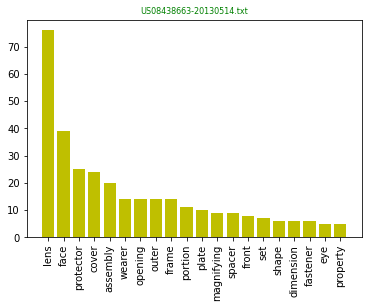

2
{'harness': 35, 'garment': 27, 'end': 25, 'strap': 15, 'handle': 12, 'connectable': 10, 'region': 10, 'rescue': 7, 'individual': 6, 'thereof': 4, 'comprising': 3, 'connection': 3, 'form': 3, 'loop': 3, 'torso': 3, 'wherein': 3, 'front': 2, 'armpit': 2, 'closure': 2, 'safety': 2}


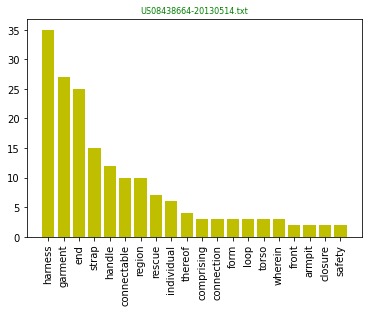

3
{'portion': 86, 'hood': 46, 'side': 35, 'garment': 26, 'neck': 26, 'margin': 25, 'drawstring': 23, 'wearer': 22, 'channel': 14, 'barrel': 13, 'lock': 13, 'configuration': 12, 'opening': 11, 'accordance': 11, 'shroud': 9, 'face': 9, 'end': 8, 'manner': 6, 'ear': 6, 'pair': 5}


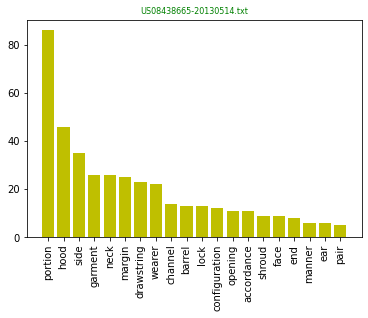

4
{'band': 92, 'surface': 74, 'side': 58, 'portion': 46, 'channel': 40, 'end': 36, 'apparatus': 20, 'opening': 8, 'member': 8, 'passageway': 8, 'shape': 8, 'direction': 8, 'part': 7, 'outer': 6, 'ear': 6, 'wearer': 6, 'length': 5, 'comprising': 4, 'boundary': 4, 'curvature': 4}


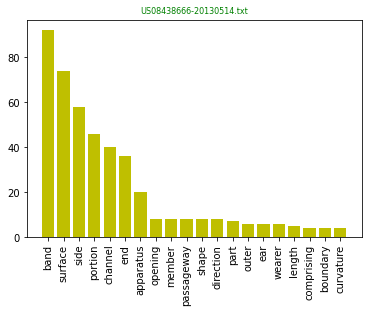

5
{'element': 58, 'fold': 43, 'apparel': 38, 'article': 37, 'textile': 33, 'surface': 27, 'area': 17, 'material': 16, 'portion': 13, 'waistband': 11, 'plurality': 8, 'component': 7, 'comprising': 6, 'form': 6, 'polymer': 6, 'foam': 6, 'configuration': 6, 'layer': 6, 'garment': 5, 'ha': 5}


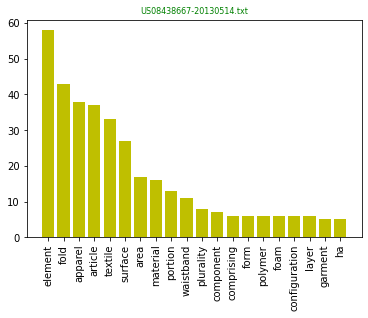

6
{'section': 64, 'end': 55, 'strap': 30, 'chin': 19, 'left': 19, 'helmet': 18, 'shell': 18, 'member': 14, 'side': 12, 'branch': 11, 'stabilization': 8, 'adjusting': 6, 'assembly': 6, 'stem': 6, 'claimed': 4, 'wearer': 3, 'cranium': 3, 'portion': 3, 'relationship': 3, 'casket': 3}


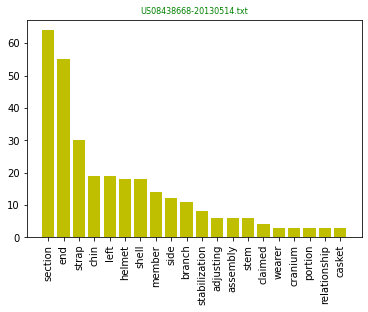

7
{'material': 41, 'apparel': 32, 'article': 31, 'element': 28, 'layer': 26, 'fastening': 24, 'system': 24, 'part': 22, 'plate': 21, 'portion': 18, 'pad': 14, 'shoulder': 13, 'polymer': 11, 'wearer': 11, 'cushioning': 10, 'torso': 9, 'foam': 7, 'neck': 6, 'plurality': 4, 'aperture': 4}


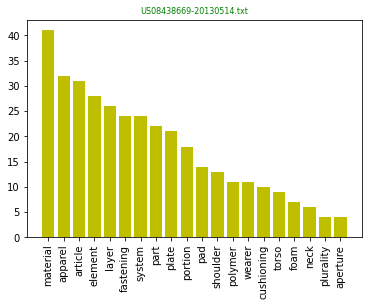

8
{'toilet': 48, 'system': 37, 'cycle': 37, 'area': 36, 'bowl': 25, 'gravity': 21, 'outlet': 20, 'port': 16, 'liter': 16, 'water': 13, 'flush': 12, 'jet': 12, 'volume': 12, 'arop': 10, 'valve': 9, 'rate': 9, 'apm': 8, 'ajip': 8, 'tank': 7, 'fill': 7}


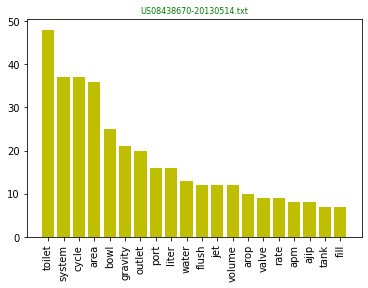

9
{'pool': 77, 'cover': 44, 'structure': 33, 'element': 31, 'seating': 28, 'top': 25, 'housing': 23, 'head': 21, 'system': 20, 'sidewall': 20, 'pressure': 20, 'extension': 19, 'surface': 18, 'adjustment': 18, 'cylinder': 18, 'trough': 17, 'valve': 17, 'position': 16, 'actuator': 15, 'control': 15}


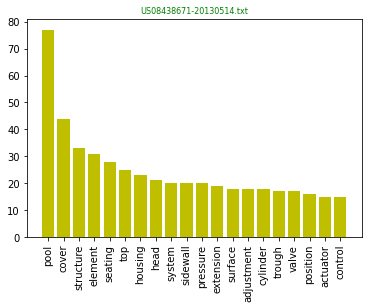

10


In [8]:
import numpy as np 
import matplotlib.pyplot as plt
from itertools import islice

plt.clf()

patent_docs_KW20_string ={}

for doc_name, KW_stat in patent_docs_KW.items():
  common20 = dict(islice(KW_stat.items(), 20))
  print(common20)
  patent_docs_KW20_string[doc_name] = ' '.join(common20.keys())
  x = np.arange(20)
  y = common20.values()
  plt.title( doc_name, fontsize=8, color='g')
  plt.xticks(x, common20.keys(),  rotation='vertical')
  # plt.bar(x, y)
  # plt.bar(x, y, color='y')
  plt.bar(x, y, color='y')
  plt.show()


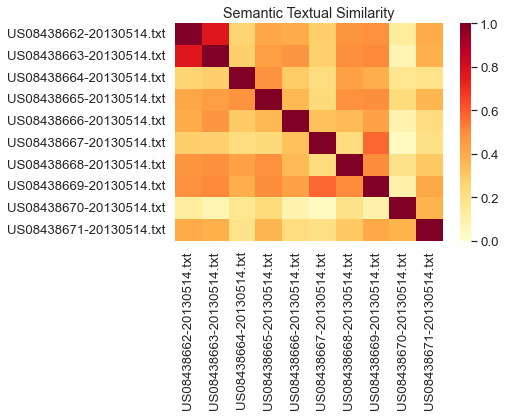

In [12]:
import seaborn as sns
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
#embeddings = embed([
#    "france",
#    "germany",
#    "boy"
#    ])
#print(embeddings)

def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(list(patent_docs_KW20_string.values()))
  plot_similarity(list(patent_docs_KW20_string.keys()), message_embeddings_, 90)


#patent_docs_KW20_string

messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
]

run_and_plot(patent_docs_KW20_string)